# Social Computing - Summer 2019
# Exercise 4 - Social Tie Strength

In this exercise, you are going to predict tie strength in a social network using the method explained in [1]. According to Mark Granovetter, the strength of a tie between two persons is a combination of the amount of time, the emotional intensity, the intimacy and the reciprocal services which characterize it. Using variables that describe these categories, we want to find that combination in order to predict the strength of ties not previously known.<br>
An important prerequisite to this exercise is understanding the basic concept of linear regression models. As mentioned in the lecture, a recommended reading is chapter 3 of [2].

[1] E. Gilbert and K. Karahalios: _Predicting Tie Strength With Social Media_. Proceedings of the SIGCHI Conference on Human Factors in Computing Systems. ACM, 2009.<br>
[2] C. Bishop: _Pattern Recognition and Machine Learning_. 2006.

### Tie Strength Prediction

In social network analysis, the tie strength between to people measures how strong their relationship is. The paper above describes the procedure of deriving available information (different variables) about a connection between two persons from an online social network and using it in order to discover how close they are. The ultimate goal is to build a model using the given information, finding out which variables account most for the tie strength and using that model later on to predict social tie strength when only the predictive (or explanatory) variables are available. Before being able to predict anything, we need to find out whether the given variables are suitable for prediction in the first place. This can be done via creating and evaluting a **multiple linear regression model**. 'Multiple' here refers to more than one predictive variables in an regression model.<br>
In the paper mentioned above, 67 variables where used in the linear model to predict the tie strength. In our simplified model, we are going to use only 10 predictive variables which are:

1. Number of friends (I)
2. Friends' number of friends (I)
3. Days since last communication (I)
4. Appearance together in photos (I)
5. Wall intimacy words (I)
6. Inbox intimacy words (I)
7. Days since first communication (D)
8. Number of mutual friends (S)
9. Age distance (SD)
10. Educational distance (SD)<p>
    
With (I) being **intimacy** variables, (D) **duration** variables, (S) **structural** variables and (SD) **social distance** variables.

We are going to use a simplified form of the paper's linear model:
$$y_i = \alpha + \beta X_i + \epsilon_i$$

where $y_i$ is the dependent variable (also referred to as target value, which is the tie strength in our case) of the $i$-th friend of a person. $X_i$ is the predictive vector, containing the (predictive) variables listed above. $\alpha$ and $\beta$ are the model's parameters, where $\alpha$ is the intercept/bias, $\beta$ the coefficient vector containing coefficients for each predictive variable, and $\epsilon$ the prediction error. The regression problem boils down to calculating the model's parameters given a certain ground truth; meaning that for some connections, the tie strength has to be already known for building the model. That way, the unknown tie strengths can be predicted using the regression model by simply inserting the values in the vector.

### Problem Overview

The input to your Python program is a directed social network _SocialGraph.gml_. The GML format is human-readable and similar to the GraphML format used in exercise 2. Just open the file in your text editor and examine the nodes' and edges' attributes. Using igraph again, you can convert it into a Graph object.

In practice, the ground truth (tie strength) is usually retrieved by participant's answers to surveys how strong their relationship is with another person - this is why the graph is directed, two people might have varying views. The ground truth is available in the file. About 70% of the edges have valid values for the `tieStrength` variable, which should be used for training. For about 30% of the edges, the variable is set to -1 (equivalent to unknown). These represent the testing set for which the tie strength should be predicted using the linear regression model later. But first, that model needs to be computed and checked for its goodness of fit.

## Imports and Visualization
At first, needed libraries and the graph have to be imported. The social graph is visualized in order to get an idea what the network actually looks like.

If you need information on how to work with igraph's graph structure, you can look it up in the [igraph manual](https://igraph.org/python/doc/igraph-module.html). For the purpose of working with an larger datasets, you need to save the variables in a suitable data format. In our case, the pandas library is a good choice. For more information on the library, see the [pandas manual](https://pandas.pydata.org/pandas-docs/version/0.19.2) and its [tutorial](https://pandas.pydata.org/pandas-docs/version/0.19.2/10min.html) to pandas dataframes. - pay attention to the version there if you installed the libraries manually. Apart from that, we will be working with the [statsmodels module](https://www.statsmodels.org/stable/index.html) for the regression model.

In [1]:
from statsmodels.api import add_constant
import igraph as ig, numpy as np, pandas as pd, statsmodels.api as sm, matplotlib.pyplot as plt

g = ig.Graph.Read_GML('SocialGraph.gml')

# Formatting the graph
visual_style = {}
visual_style['vertex_size'] = 10
visual_style['vertex_label'] = g.vs['id']
visual_style['bbox'] = (700, 700)
visual_style['margin'] = 50

ig.plot(g, **visual_style)

## Problem 4.1: Completing The Social Graph

If you inspected the _SocialGraph.gml_ file, you may have observed that some of the ten predictive variables are already present as node or edge attributes while others are not. In order to later compute the linear model with these ten predictive variables, the missing values are needed. Luckliy, they can be calculated from the already existing ones. **Therefore, your first task is to complete the social graph by calculating all the missing nodes/edges attributes.** Save the vectors with known tie strength as training data in a seperate dataframe as the unknown ones (since those are used for prediction later). Output the first ten entries of the training table.

**Notes:**
* It is recommended to first work with lists when computing the missing variables and converting it into a pandas dataframe afterwards. Look up the function `Dataframe()` in the manual for creating a one.
* Use `head(n)` on a dataframe to output the first n entries.
* Pay attention to the data types of the features.

In [2]:
# Calculates the missing values for current edge e of graph g
def calculate_missing_variables(g, e):
    # Source and target nodes for current edge
    src = g.vs[e.source]
    tgt = g.vs[e.target]
    
    # Number of friends (I)
    # Friends' number of friends (I)
    # Days since last communication (I)
    # Appearance together in photos (I)
    # Wall intimacy words (I)
    # Inbox intimacy words (I)
    # Days since first communication (D)
    # Number of mutual friends (S)
    # Age distance (SD)
    # Educational distance (SD)
    
    # Calculate the other variables from existing ones
    src_neighbors = src.neighbors(mode='OUT')
    tgt_neighbors = tgt.neighbors(mode='OUT')
    
    num_friends = src.outdegree()
    friends_num_friends = sum(g.degree(src_neighbors))
    num_mutual_friends = len(set(src_neighbors) & set(tgt_neighbors))
    age_diff = abs(src['age'] - tgt['age'])
    edu_diff = abs(src['numAcDegrees'] - tgt['numAcDegrees'])
    
    # Create row for dataframe
    row = [num_friends, friends_num_friends, e['lastComm'], e['photosTogether'],\
           e['wallIntimWords'], e['inboxIntimWords'], e['firstComm'],\
           num_mutual_friends, age_diff, edu_diff, e['tieStrength']]

    return row


# Training and prediction lists
train_list = []
pred_list = []
cols = ['#Friends', 'Friends\' #Friends', '#Days Since Last Comm',\
        '#Photos', '#Wall Intimacy Words', '#Inbox Intimacy Words',\
        '#Days Since First Comm','#Mutual Friends', 'Age Dist',\
        'Educational Diff', 'Tie Strength']

# Calculate rows (one for each edge) and add them to tables
for e in g.es:
    row = calculate_missing_variables(g, e)
    
    # Append to respective list
    if row[-1] > 0:
        train_list.append(row)
    else:
        pred_list.append(row)
        
# Create training and prediction tables
train_table = pd.DataFrame(data=train_list, columns = cols)
pred_table = pd.DataFrame(data=pred_list, columns = cols)

print(train_table.head(10))

   #Friends  Friends' #Friends  #Days Since Last Comm  #Photos  \
0        16                914                  173.0     12.0   
1        16                914                  168.0     13.0   
2        16                914                  239.0      5.0   
3        16                914                  201.0      9.0   
4        16                914                  169.0     12.0   
5        16                914                  142.0     17.0   
6        16                914                  178.0     11.0   
7        16                914                  135.0     17.0   
8        16                914                  173.0     13.0   
9        16                914                  116.0     21.0   

   #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
0                  48.0                  243.0                  1726.0   
1                  57.0                  334.0                  1709.0   
2                  13.0                   88.0     

## Problem 4.2: Prediction of Tie Strengths
Now that the social graph is completed, the multiple linear regression model presented above can be computed. Remember that the goal is to find a model that fits the data well and has explanatory power over the tie strength. That way, further tie strengths that are unknown can be predicted using the regression model. To ensure that the model is meaningful, it needs to be evaluated and examined for its goodness of fit. You will start with preparing the data in the tasks, followed by the just mentioned procedure.

### Task 1: Log-Transformation
In data analysis, transformation is the replacement of a variable by a function of that variable. For example, replacing a variable $x$ by its square root $\sqrt{x}$ or its logarithm $\log{x}$. In a stronger sense, it means a replacement that changes the shape of a distribution or relationship. There are many reasons for transformations. The following list are a few of them but it is not comprehensive:

1. Convenience
2. Reducing skewness
3. Equal spreads
4. Linear relationships
5. Additive relationships

If you are looking at just one explanatory variable, points 1, 2 and 3 are relevant. But concerning two or more variables, points 4 and 5 are more important. However, transformations that achieve 4 and 5 very often fulfill 2 and 3 as well. In our case, a logarithm transformation on the predictibe variables will be used.

With the help of numpy's `log` function, **apply the log-transformation on each feature vector for the training table (but not the tie strength)**. Pay attention to the fact that $\log{0}$ is not defined, a small number (e.g. 0.000001) should be added before the transformation! Again, output the first ten entries of your dataframe.

In [3]:
train_table_log = pd.DataFrame(columns=cols)

# Fill the log training table and apply log-transformation on predictive variables
train_table_log = np.log(train_table.drop('Tie Strength', axis=1) + 0.000001)
train_table_log = train_table_log.join(train_table[['Tie Strength']])
print(train_table_log.head(10))

   #Friends  Friends' #Friends  #Days Since Last Comm   #Photos  \
0  2.772589           6.817831               5.153292  2.484907   
1  2.772589           6.817831               5.123964  2.564949   
2  2.772589           6.817831               5.476464  1.609438   
3  2.772589           6.817831               5.303305  2.197225   
4  2.772589           6.817831               5.129899  2.484907   
5  2.772589           6.817831               4.955827  2.833213   
6  2.772589           6.817831               5.181784  2.397895   
7  2.772589           6.817831               4.905275  2.833213   
8  2.772589           6.817831               5.153292  2.564949   
9  2.772589           6.817831               4.753590  3.044522   

   #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
0              3.871201               5.493061                7.453562   
1              4.043051               5.811141                7.443664   
2              2.564949               4.

### Task 2: Building The Regression Model
Finally, the regression can be applied on the dataframe. For this purpose, split the dataframe into the target and predictive variables into variables $y$ and $X$. A constant term, corresponding to the bias $\alpha$ in the mathematical definition above, needs to be added to the regression before its computation. It represents the target value when all explanatory variables are zero - think of it as a baseline. If there was no intercept, the model would be less meaningful. You can add the intercept with `add_constant(X)`.

Now apply a multiple linear regression on the training table, the statsmodels functions `OLS()` and `fit()` will help you with that. Output the summary with the help of `summary()`. **State what the coefficients tell you about the influence of the respective features for predicting the tie strength. Which kind of variables (I, D, S, SD) have the most influence? Does it match the findings of the paper referenced in [1]?** Note that the coefficients do not need to be high or within the [-1,1] range, but can be. Take into account other statistics for your evaluations. **For example, what does the (adjusted) R-squared value say about the prediction?** Do not write more than 7 sentences overall.

In [4]:
# Split dataframe in target and predictive variables
y = train_table_log[['Tie Strength']]
X = train_table_log.drop('Tie Strength', axis=1)

# Add the intercept
X = add_constant(X)

# Apply OLS regression
results = sm.OLS(y, X).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:           Tie Strength   R-squared:                       0.654
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     664.4
Date:                Sun, 30 Jun 2019   Prob (F-statistic):               0.00
Time:                        13:35:43   Log-Likelihood:                 3834.9
No. Observations:                3526   AIC:                            -7648.
Df Residuals:                    3515   BIC:                            -7580.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

**Your discussion here!**

We can see that `#Inbox Intimacy Words`, `#Days Since First Comm`, `#Friends` and `#Days Since Last Comm` have the largest absolute coefficient values, which means these are the features most strongly correlated with the tie strenght. In the case of `#Days Since Last Comm`, the coefficient is negative, which means it is inversly correlated with tie strength (this is intuitive: the fewer days since last communication, the strongest we expect the tie to be.

The most influencial variable types are therefore I (intimacy) and D (duration), while S (structure) and SD (social distance) variables proved to have little influence. This matches the results described on the paper, where both the I and D dimentions account for a big percetage of the model's capability. Furthermore, some of the variables with the largest coefficients also coincide with results from the paper, e.g. `#Days Since First Comm` and `#Days Since Last Comm`.

The adjusted $R^2$ value is 0.653, which represents how much of the data's variance is explained by the model. Even though this means our model is not very reliable, this is not unexpected, as social ties are a very complex measure, that could hardly be explained by 10 simple social media variables.

### Task 3: Prediction of Tie Strengths
As a last step, the missing values (marked with -1) for some tie strength entries should be predicted using the before computed regression model. **Use the regression model to predict the missing tie strength values.** Statsmodels will be of help with that. Remember that we transformed the training data with a log-transform and added an intercept, so this needs to be done here as well. Output the first ten entries.
    
**Are the predictions in line with the observations above? Pick a few entries to back up your observations.** If you would like to talk about other than the first ten entries, you can query a pandas dataframe similar to SQL. More information on how to do this is available in the [pandas documenation](https://pandas.pydata.org/pandas-docs/version/0.19.2/comparison_with_sql.html). Do not write more than 3 sentences.

**Note:** Values outside the realistic range in the interval of (0,1) for the tie strength might exist because of very low/high values for some predictive variables in the dataset. You can consider them as almost 0/1.

In [12]:
# Split dataframe
pred_table_log = pd.DataFrame(columns=cols[:-1])

# TODO: Apply log-transform on prediction table
pred_table_log = np.log(pred_table.drop('Tie Strength', axis=1) + 0.000001)

# TODO: Add constant term
pred_table_log = add_constant(pred_table_log)
    
# TODO: Predict the tie strengths
ypred = results.predict(pred_table_log)
print(pred_table.head(10))
print("\nTie strenght predicted values:\n")
print(ypred[:10])

   #Friends  Friends' #Friends  #Days Since Last Comm  #Photos  \
0        16                914                  300.0     47.0   
1        16                914                  245.0     20.0   
2        16                914                  124.0     25.0   
3        16                914                  116.0      8.0   
4         9                286                   88.0     31.0   
5         9                286                  120.0     17.0   
6         9                286                  130.0     38.0   
7         9                286                  224.0     16.0   
8        16               1306                  339.0     25.0   
9        16               1306                  174.0      1.0   

   #Wall Intimacy Words  #Inbox Intimacy Words  #Days Since First Comm  \
0                 149.0                  442.0                  3352.0   
1                 959.0                  426.0                   274.0   
2                 980.0                  575.0     

**Your discussion here!**

We can see that some variables obviously have more influence in the predicted tie strenght than others: for example, edges 5 and 6 shows a large tie strenght (0.36 and 0.31 respectively), despite a rather large age difference (44 and 38 respectively), proving that this variable does not have a very big influence.

On the other hand, if we look at the number of inbox intimacy words, we can see it how it changes the tie strenght: edge 3 has the largest number of inbox intimacy words (694) and also the strongest tie (0.43), while edge 4 has the smallest of both values (5 and 0.06).

## (Optional) Problem 4.3: Goodness of Fit
After looking at a few entries in the prediction output, there is a strong presumption on how good the linear regression model's fit is. Nevertheless, it can be analyzed with tools whether it represents the data well and if the predictions are actually meaningful. There are several methods to evaluate the goodness of a regression. In this exercise, you will work with two of them: the QQ-plot and plotting residuals. You can find information on the topic [here](https://degninou.net/2016/02/04/multiple-regression-and-diagnostics-with-python)

**Note:** This problem is **optional**. You do not have to do this task in order to get the full grade but you can still improve if you were not able to solve the other problems sufficiently.

### Task 1: QQ-Plot
Create a QQ-plot and evaluate what the result means for your fit? Don't write more than 4 sentences.

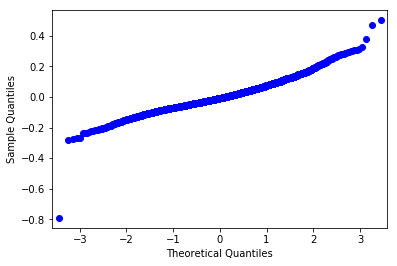

In [6]:
# TODO: Show QQ-plot
fig = sm.qqplot(results.resid)
plt.show()

**TODO: Your interpretation here!**

### Task 2: Residual Plot
Now evaluate your fit by plotting the residuals. What does the result tell you regarding your fit? Don't write more than 4 sentences.

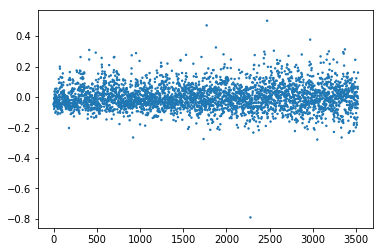

In [31]:
# TODO: Plot standardized residuals

s = [2] * len(results.resid)
plt.scatter(range(len(results.resid)), results.resid, s=s)

**TODO: Your interpretation here!**